# STAT 301 Final Report

#### Group 10: Stellar Shar, Charles Deng, Ibrahim Sajid, Kevin Li

In [9]:
library(readr)
library(dplyr)
library(tidyverse)
library(tidyr)
library(leaps)
library(ggplot2)

## 1. Introduction

Online food delivery has become a huge part of how we eat today. It's not just about convenience anymore; for many people, it's an everyday necessity. The industry is growing fast, about 9% each year, and could be worth nearly $2 trillion by 2029 according to recent research (Mohamadabadi et al., 2024). One of the most important things customers look at when ordering is the star rating. Research shows people trust these ratings almost as much as personal recommendations (Selvaraj & Nallasivam, 2023).

This got us thinking: Could we predict a restaurant's star rating just by looking at basic information like its price range, how many reviews it has, how far it delivers, and what city it's in? Using real data from DoorDash in Canada, we're trying to build a model that does exactly that. We're not trying to figure out why certain restaurants get better ratings (that would require different methods), but rather see if we can make accurate predictions based on what we can observe.

This approach builds on what we know from previous studies about how important ratings are in food delivery apps, while focusing on a practical prediction problem that could help both the platforms and restaurant owners. The idea is that if we can predict ratings well, it might help restaurants understand what factors matter most to customers, and help platforms improve their recommendation systems.

**Research Question**:

## 2. Methods and Results

#### Part A: Exploratory Data Analysis (EDA)

The dataset we use is [Food Delivery in Canada (DoorDash)](https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash), with variables listed in the table below. It contains data on food delivery orders in Canada, focusing on restaurants with under 30-minute delivery times using iconic downtown addresses for each city on the DoorDash platform. The dataset has 9 variables and 3,290 observations, including order-related information such as restaurant details, delivery distance, price range, and more. These data are collected from DoorDash's public website without experimental manipulation, making this an observational dataset.

| **variable**       | **type**       | **description**                                                                 |
|--------------------|----------------|---------------------------------------------------------------------------------|
| restaurant         | text           | Name of the restaurant.                                                         |
| url                | text           | Restaurant menu page URL.                                         |
| distance           | numeric        | Distance from the order location to the restaurant (in miles).                  |
| star               | numeric        | Star rating of the restaurant (out of 5).                               |
| num_reviews        | numeric        | Number of reviews for the restaurant.                                           |
| city               | categorical    | City where the order is placed (levels: Brampton, Calgary, Edmonton, Montreal, Ottawa, Toronto, Vancouver, Winnipeg).                                              |
| price              | categorical    | Price range of the restaurant (levels expressed in 1 to 4 dollar signs).                        |
| category_1         | text           | Primary cuisine type (e.g., indian, chinese, bakery, fast food).                |
| category_2         | text           | Secondary menu category (e.g., biryani, burgers, noodles, vegetarian).          |

In our analysis, we will exclude variables like restaurant name, URL, and category 1 and 2, since they are either not directly related to predicting star ratings or lack clarity in what they represent.

In [29]:
# Load data
url <- "https://raw.githubusercontent.com/KevinL002/STAT_301_group_10/refs/heads/main/cleaned_full_data.csv"

dataset <- read_csv(url, show_col_types = FALSE)
colnames(dataset)[1] <- "index"

# Data Processing
cleaned_data <- dataset %>%
    mutate(price_range = fct_collapse(price_range, "$$$+" = c("$$$", "$$$$"))) %>% #(optional-bias)
    mutate(city_size = case_when(city %in% c("Vancouver", "Calgary", "Toronto", "Montreal") ~ "Big City", 
                                 TRUE ~ "Small City")) %>%  # Classify city size by their population
    select(-1, -2, -3, -city, -category_1, -category_2) %>%  # Select useful variables
    mutate(city_size = factor(city_size)) %>%
    drop_na()

head(cleaned_data)
# table(cleaned_data$price_range)

New names:
• `` -> `...1`


distance,star,num_reviews,price_range,city_size
<dbl>,<dbl>,<dbl>,<fct>,<fct>
0.90,4.0,640,$$,Small City
2.00,4.0,301,$$,Small City
1.00,4.2,890,$$,Small City
0.40,4.4,109,$,Small City
0.09,4.5,481,$$,Small City
0.90,3.7,730,$$,Small City


#### Part B: Visualization

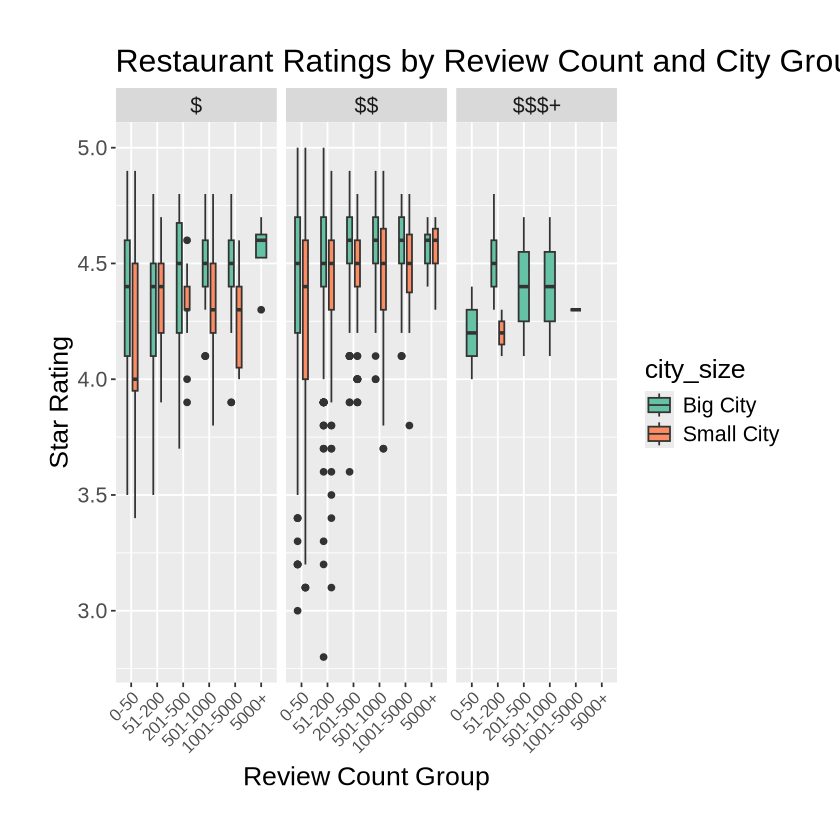

In [61]:
cleaned_data <- cleaned_data |>
    mutate(review_group = cut(num_reviews,
                            breaks = c(0, 50, 200, 500, 1000, 5000, Inf),
                            labels = c("0-50", "51-200", "201-500", "501-1000", "1001-5000", "5000+")))

ggplot(cleaned_data, aes(x = review_group, y = star, fill = city_size)) +
    geom_boxplot(position = position_dodge(width = 0.6), width = 0.4) +
    facet_grid(~ price_range) +
    labs(title = "Restaurant Ratings by Review Count and City Group",
         x = "Review Count Group",
         y = "Star Rating") +
    theme(text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
          plot.margin = margin(30, 30, 30, 30)) +
  scale_fill_brewer(palette = "Set2")


Figure 4: Heatmap of all inputs


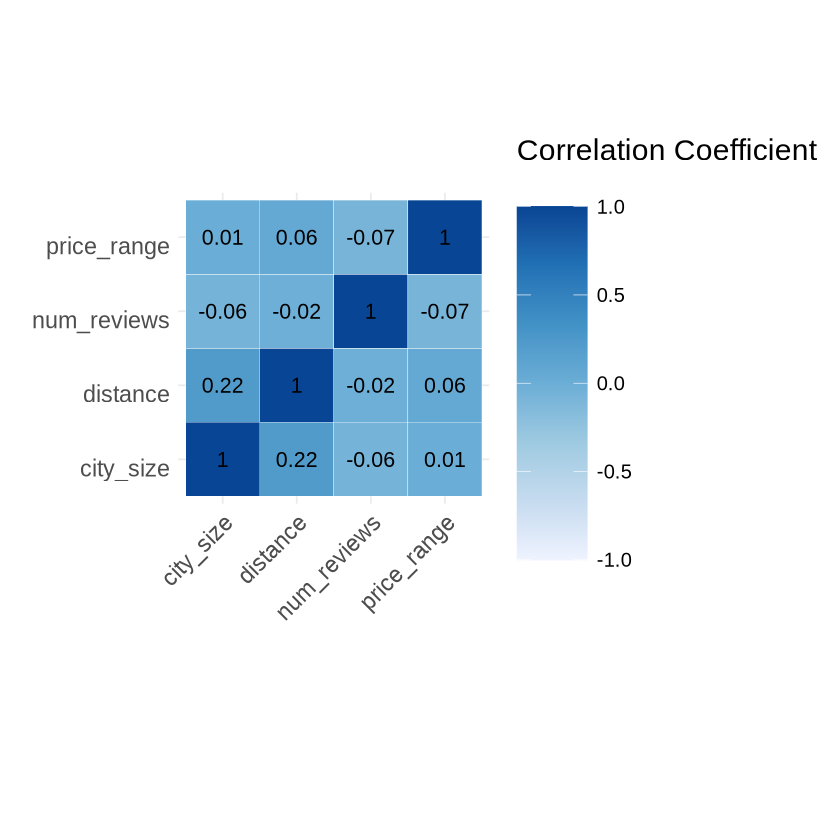

In [71]:
# Calculate the correlation
corr_matrix <- cleaned_data %>%
  mutate(price_range = as.numeric(factor(price_range)),
         city_size = as.numeric(factor(city_size))) %>%
  select(-star) %>%
  select(where(is.numeric)) %>%
  cor() %>%
  as_tibble(rownames = 'var1') %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

# plot the heatmap
corr_plot <- corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
                         palette = "Blues",
                         direction = 1, 
                         limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
corr_plot

cat("Figure 4: Heatmap of all inputs\n")

The correlation between these 4 variables is reasonable and all are less than 0.3, indicating low multicollinearity and the potential for combined predictive power.

## 3. Discussion

## 4. References

Dataset Citation:
Data source: Satoshi_S. (2022). Food delivery in Canada (Door Dash) [Data set]. Kaggle. https://www.kaggle.com/datasets/satoshiss/food-delivery-in-canada-door-dash

Mohamadabadi, T. A., Nazarian-Jashnabadi, J., Daryani, M. A., Al-Rashid, M. A., & Campisi, T. (2024). Factors affecting online customer experience of food delivery services during crisis: TISM and Delphi techniques. *Sustainable Futures*, 100408. https://doi.org/10.1016/j.sftr.2024.100408

Selvaraj, C., & Nallasivam, A. (2023). Reflection of star ratings on online customer reviews; its influence on consumer Decision-Making. In *Lecture notes in networks and systems* (pp. 107–128). https://doi.org/10.1007/978-981-19-6634-7_9